In [1]:
import fio.database
import mip

db = fio.database.load_db("data/base.json")

print(db.keys())

dict_keys(['assemblers', 'items', 'miners', 'modules', 'recipes', 'resources', 'versions'])


In [2]:
import functools

@functools.lru_cache(64)
def get_assembly_machines(category, craftable_only=True):
  ms = []

  for m in db.assemblers.find(f""".[] | select(.crafting_categories | contains(["{category}"]))"""):
    ms.append(m)

  return ms

recipes = fio.database.HyperDiGraph()

ignore_machines = []

for r in db.recipes.find(".[]"):
    for m in get_assembly_machines(r['category']):

        if m["name"] in ignore_machines:
            continue

        A = {i["name"] for i in r["ingredients"]}
        B = {p["name"] for p in r["products"]}
        recipes.add_edge(A, B, {"recipe": r, "machine": m, "name": f"{r['name']}#{m['name']}"})


In [3]:
import json
from collections import defaultdict

# Load a sample JSON file
with open('data/base.json', 'r') as json_file:
    data = json.load(json_file)



# Analyze the JSON data
def analyze_json(json_data, output=None, parent_key=[]):
    if output is None:
        output = defaultdict(set)
    if isinstance(json_data, dict):
        for key, value in json_data.items():
            new_key = parent_key + [key]
            analyze_json(value, output, parent_key=new_key)
    elif isinstance(json_data, list):
        for item in json_data:
            analyze_json(item, output, parent_key=parent_key)
    else:
        output[tuple(parent_key)].add(type(json_data))
    
    return output

# Call the analyze_json function on the JSON data
analyze_json(data)

defaultdict(set,
            {('assemblers', 'allowed_effects', 'consumption'): {bool},
             ('assemblers', 'allowed_effects', 'pollution'): {bool},
             ('assemblers', 'allowed_effects', 'productivity'): {bool},
             ('assemblers', 'allowed_effects', 'speed'): {bool},
             ('assemblers', 'crafting_categories'): {str},
             ('assemblers', 'crafting_speed'): {float, int},
             ('assemblers', 'ingredient_count'): {int},
             ('assemblers', 'module_inventory_size'): {int},
             ('assemblers', 'name'): {str},
             ('items', 'name'): {str},
             ('items', 'stack_size'): {int},
             ('items', 'type'): {str},
             ('miners', 'allowed_effects', 'consumption'): {bool},
             ('miners', 'allowed_effects', 'pollution'): {bool},
             ('miners', 'allowed_effects', 'productivity'): {bool},
             ('miners', 'allowed_effects', 'speed'): {bool},
             ('miners', 'mining_speed'): 

In [4]:
import fio.flow


source = dict(**{resource: float("+inf") for resource in db.resources.query("map(.products[].name) | unique")})

target = {
    k: 1 for k in {
        # 'basic-tech-card',
        # 'advanced-tech-card',
        # 'automation-science-pack',
        # 'biters-research-data',
        # 'chemical-science-pack',
        # 'logistic-science-pack',
        # 'production-science-pack',
        # 'utility-science-pack',
        # 'matter-research-data',
        # 'matter-tech-card',
        # 'military-science-pack',
        # 'singularity-tech-card',
        # "logistic-science-pack"
        "advanced-logistic-science-pack",
        # "alien-science-pack",
        # "alien-science-pack-blue",
        # "alien-science-pack-green",
        # "alien-science-pack-orange",
        # "alien-science-pack-purple",
        # "alien-science-pack-red",
        # "alien-science-pack-yellow",
        "automation-science-pack",
        "chemical-science-pack",
        "logistic-science-pack",
        "military-science-pack",
        "production-science-pack",
        "science-pack-gold",
        "space-science-pack",
        # "steam-science-pack",
        "utility-science-pack",

    }
}

print(source)

model = fio.flow.optimize_model(recipes, dict(**source, **{k: -v for k, v in target.items()}))

print(model["status"])
# model = build_detailed_graph(model)

{'coal': inf, 'copper-ore': inf, 'crude-oil': inf, 'iron-ore': inf, 'stone': inf, 'uranium-ore': inf}
Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 206 (-582) rows, 302 (-850) columns and 760 (-2469) elements
Clp0029I End of values pass after 260 iterations
Clp0014I Perturbing problem by 0.001% of 3.8553482 - largest nonzero change 0 ( 0%) - largest zero change 2.982246e-05
Clp0001I Primal infeasible - objective value 2175.3294
Coin0505I Presolved problem not optimal, resolve after postsolve
Coin0511I After Postsolve, objective 2175.3297, infeasibilities - dual 13.54317 (5), primal 0.80607544 (12)
Clp0014I Perturbing problem by 1e-08% of 23.286057 - largest nonzero change 9.9929689e-07 ( 0.00037417979%) - largest zero change 0
OptimizationStatus.INFEASIBLE
Clp0001I Primal infeasible - objective value 2175.32
Clp0032I PrimalInfeasible objective 2175.32 - 274

In [5]:

from collections import defaultdict, namedtuple

inputs = defaultdict(float)
outputs = defaultdict(float)
c = defaultdict(int)


flows = []
i = 0


from uuid import uuid4

Cell = namedtuple("Cell", ["id", "recipe", "machine", "intergral", "fractional"])

class unique:
  def __init__(self, klass):
    self.c = defaultdict(int)
    self.klass = klass
  def __call__(self, i):
    r = self.c[i]
    self.c[i] += 1
    return f"{self.klass}_{i}_{r}"

unique_id = unique("transfo")

import networkx as nx
graph = nx.DiGraph()

per_rows = 4
for r, m, k, f in [tuple(k.split("#") + list(v)) for k, v in model["flow"].items()]:
    c[m] += k

    r = db.recipes.query(f"""map( select(.name == "{r}"))""")[0]

    m1 = db.assemblers.query(f"""map( select(.name == "{m}")) """)
    # m2 = db.furnace.query(f"""map( select(.name == "{m}")) """)
    m = (m1)[0]

    for _ in range(k-1):
      i = unique_id(r["name"])
      flows.append(Cell(i, r, m, 1, 1))
      graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=1)

    assert f-k+1 > 0
    i = unique_id(r["name"])
    flows.append(Cell(i, r, m, 1, f-k+1))
    graph.add_node(i, kind="transformator", recipe=r, machine=m, k=1, f=f-k+1)



KeyError: 'flow'

In [6]:
nodes = list(graph.nodes(data=True))

new_graph = graph.copy()
for n, info in nodes:
  for i in info["recipe"]["ingredients"]:
    new_graph.add_edge(f'{i["type"]}_{i["name"]}', n, weight=i["amount"] * info["f"])
  
  for r in info["recipe"]["products"]:
    new_graph.add_edge(n, f'{r["type"]}_{r["name"]}', weight=i["amount"] * info["f"])

  
for n, info in new_graph.nodes(data=True):
  if "kind" not in info:
    info["kind"] = "product"


In [65]:
# For each machine, we need a blueprint of known size, parametrized in the recipe that tka einputs as a requester chest, and outputs as an storage chest.

# Then we need to build the thing by placing elements one by one.

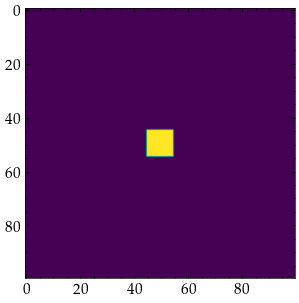

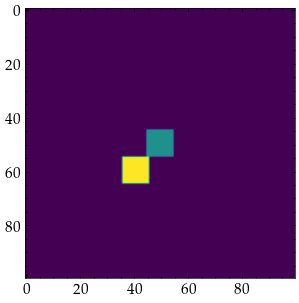

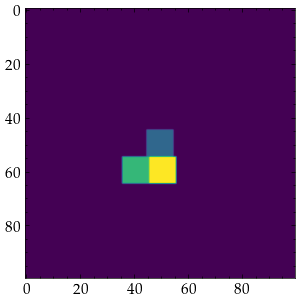

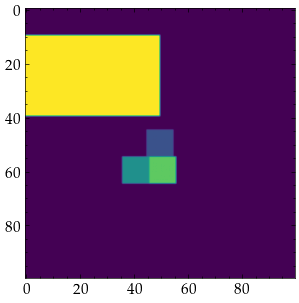

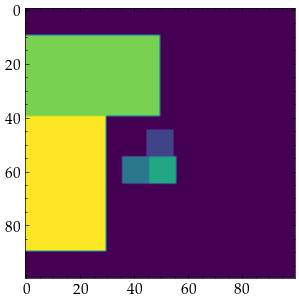

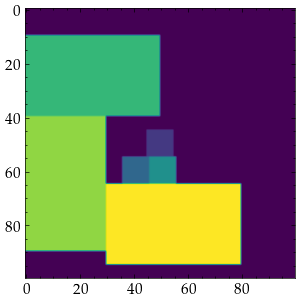

In [66]:
from itertools import product
def spiral_out_generator():
    """This function generate the successives positions to generate a spiral."""
    layer = 1
    leg = 0
    x, y = 0, 0
    while True:
        yield x, y
        if leg == 0:
            x += 1
            if x == layer:
                leg += 1
        elif leg == 1:
            y += 1
            if y == layer:
                leg += 1
        elif leg == 2:
            x -= 1
            if -x == layer:
                leg += 1
        elif leg == 3:
            y -= 1
            if -y == layer:
                leg = 0
                layer += 1

def find_nearest_unoccupied_cell(h, w, i, j, mask):
    spiral = spiral_out_generator()
    for _ in range(mask.shape[0] * mask.shape[1]*8):
        ni, nj = next(spiral)
        ni, nj = i + ni, j + nj

        w1 = int(ni - np.floor(w/2))
        w2 = int(ni + np.ceil(w/2))

        h1 = int(nj - np.floor(h/2))
        h2 = int(nj + np.ceil(h/2))

        sizew, sizeh = mask.shape

        if not ((0 <= h1 <= h2 < sizeh) and (0 <= w1 <= w2 < sizew)):
            continue

        if np.all(mask[w1:w2, h1:h2] == 0):
            return ni, nj
    
    return None

def positionnate_cell(h, w, i, j, mask, o):
    res = find_nearest_unoccupied_cell(h, w, i, j, mask)

    if res is None:
        return "err"
    else:
        ni, nj = res
        w1 = int(ni - np.floor(w/2))
        w2 = int(ni + np.ceil(w/2))

        h1 = int(nj - np.floor(h/2))
        h2 = int(nj + np.ceil(h/2))
        mask[w1:w2, h1:h2] = o

        return "ok"


import matplotlib.pyplot as plt


import numpy as np
mask = np.zeros((100, 100))

objects = [
    (50, 50, 10, 10),
    (50, 50, 10, 10),
    (50, 50, 10, 10),
    (10, 10, 30, 50),
    (10, 10, 50, 30),
    (10, 10, 30, 50),
]

plt.imshow(mask)
for o, (i, j, w, h) in enumerate(objects, start=1):
    positionnate_cell(h, w, i, j, mask, o)
    plt.imshow(mask)
    plt.show()


# Blueprint construction

We don't need for each recipes to create a new blueprint: we only need one blueprint for each machines and fluids inputs and outputs.


In [67]:
import pandas as pd

df = {}

def select(kind1, kind2):
  return sum(1 for i in data["recipe"][kind1] if i["type"] == kind2)

for node, data in graph.nodes(data=True):
  if data["kind"] != "transformator":
    continue
  df[node] = {
    "machine": data["machine"]["name"],
    "recipe": data["recipe"]["name"],
    "item_in": select("ingredients", "item"),
    "item_out": select("products", "item"),
    "fluid_in": select("ingredients", "fluid"),
    "fluid_out": select("products", "fluid"),
    "data": data,
  }

df = pd.DataFrame(df).T

display(
  df.groupby(["machine", "item_in", "item_out", "fluid_in", "fluid_out"]).count()
)


recipe  data
machine                   item_in item_out fluid_in fluid_out              
advanced-chemical-plant-2 1       1        0        3               6     6
                          2       2        1        3               3     3
air-pump-4                0       0        0        1               4     4
algae-farm-4              0       1        2        0              10    10
                          1       1        2        0               7     7
...                                                               ...   ...
sintering-oven-5          1       1        0        0               1     1
                          2       1        0        0              17    17
steam-cracker-4           0       0        2        2               1     1
strand-casting-machine-4  0       1        2        1              15    15
                                           3        1               3     3

[114 rows x 2 columns]

In [68]:
# for now suppose the blueprints are just empty and all of size 15*15.

def get_blueprint(machine, recipe):
  return "", 15, 15



In [75]:
help(nx.layout)

Help on module networkx.drawing.layout in networkx.drawing:

NAME
    networkx.drawing.layout

DESCRIPTION
    ******
    Layout
    ******
    
    Node positioning algorithms for graph drawing.
    
    For `random_layout()` the possible resulting shape
    is a square of side [0, scale] (default: [0, 1])
    Changing `center` shifts the layout by that amount.
    
    For the other layout routines, the extent is
    [center - scale, center + scale] (default: [-1, 1]).
    

FUNCTIONS
    arf_layout(G, pos=None, scaling=1, a=1.1, etol=1e-06, dt=0.001, max_iter=1000)
        Arf layout for networkx
        
        The attractive and repulsive forces (arf) layout [1]
        improves the spring layout in three ways. First, it
        prevents congestion of highly connected nodes due to
        strong forcing between nodes. Second, it utilizes the
        layout space more effectively by preventing large gaps
        that spring layout tends to create. Lastly, the arf
        layout re

In [90]:
import random

total_area = 0
for n, info in new_graph.nodes(data=True):
  if info["kind"] == "transformator":
    bp, w, h = get_blueprint(info["recipe"], info["machine"])
    total_area += w * h

H = W = int(np.ceil(np.sqrt(total_area))*3)
mask = np.zeros((H, W))

pos = {k: H/2 + v * H/2 for k, v in nx.spring_layout(new_graph).items()}
pos_int = {}

l = list(new_graph.nodes(data=True))
random.shuffle(l)
for o, (n, info) in enumerate(l, start=1):
  if info["kind"] == "transformator":
    bp, w, h = get_blueprint(info["recipe"], info["machine"])
    i, j = pos[n]
    pos_int[n] = i, j
    positionnate_cell(h, w, i, j, mask, o)
  



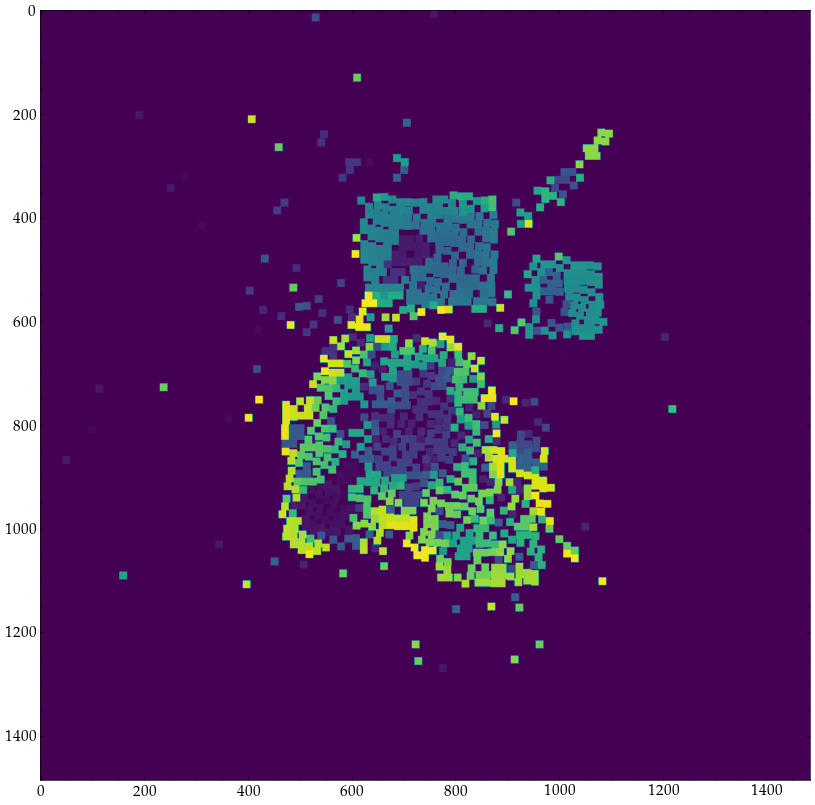

In [88]:
plt.figure(figsize=(10, 10))
plt.imshow(mask)
